In [1]:
from neo4j_utility import *
from llm_extraction import *
from firecrawl_scraping import *
from utility import *
import os
from tqdm import tqdm
from dotenv import load_dotenv

import plotly.express as px
import plotly.graph_objects as go


/Users/chenkangan/Documents/UCL DSML/Thesis/project/ucl_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
description_lst = []
description_embedding_lst = []
product_name_lst = []
company_name_lst = []
processed_name_lst = []

doc_list = os.listdir('extraction_output_v2')
for doc in doc_list:
    
    try:
        if doc in ['.DS_Store']:
            continue
        
        processed_name = doc.replace("_extraction.json", "")
        data = read_json_file(f'extraction_output_v2/{doc}')
        product_name_lst.append(data['summary_product_description']['name'])
        description_lst.append(data['summary_product_description']['description'])
        description_embedding_lst.append(data['summary_product_description']['description_embedding'])
        company_name_lst.append(data['name'])
        processed_name_lst.append(data['processed_company'])
    except Exception as e:
        print(f'Error at company {processed_name}: {e}')
    
    

'stacker_news_extraction.json', 'celebrity_agent_extraction.json'

In [3]:
doc_list = os.listdir('client_extraction_output')
for doc in doc_list:
    
    try:
        if doc in ['.DS_Store']:
            continue
        processed_name = doc.replace("_extraction.json", "")
        data = read_json_file(f'client_extraction_output/{doc}')
        
        if data['summary_product_description']:
            product_name_lst.append(data['summary_product_description']['name'])
            description_lst.append(data['summary_product_description']['description'])
            description_embedding_lst.append(data['summary_product_description']['description_embedding'])
            company_name_lst.append(data['name'])
            processed_name_lst.append(data['processed_company'])
            
        else:
            print(f'Company {processed_name} does not have summary product description.')
    except Exception as e:
        print(f'Error at company {processed_name}: {e}')

Company d_l__henricksen does not have summary product description.
Company ska_street_brewstillery does not have summary product description.
Company the_nature_conservancy does not have summary product description.
Company nfm_lending does not have summary product description.
Company pinnacle_cu does not have summary product description.
Company chevron does not have summary product description.
Company cru_group does not have summary product description.
Company zer0es_tv does not have summary product description.
Company giant_eagle does not have summary product description.
Company cbibanks does not have summary product description.
Company vodafone_com_tr does not have summary product description.
Company texas_pace_authority does not have summary product description.
Company fathom_realty_llc does not have summary product description.
Company verra does not have summary product description.
Company kraus_anderson does not have summary product description.
Company rubenstein_part

In [42]:
len(description_embedding_lst)

2074

In [43]:
len(product_name_lst)

2074

In [23]:
from sklearn.cluster import DBSCAN
import numpy as np

# Sample data: embeddings is an array of shape (8000, n_features)
# Replace with your actual data
# embeddings = np.array([...])

description_embedding_lst = np.array(description_embedding_lst)

# DBSCAN clustering
dbscan = DBSCAN(eps=0.7, min_samples=5)  # Adjust these parameters based on your data characteristics
clusters = dbscan.fit_predict(description_embedding_lst)

# Print cluster labels to see how many unique clusters there are
unique_clusters = np.unique(clusters)
print("Found clusters:", unique_clusters)

Found clusters: [-1  0  1  2  3  4  5  6  7]


In [24]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA for 2D visualization
# pca = PCA(n_components=2)
# embeddings_2d = pca.fit_transform(description_embedding_lst)

# TSNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=20)
embeddings_2d = tsne.fit_transform(description_embedding_lst)

# t-SNE for 3D visualization
tsne = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne.fit_transform(description_embedding_lst)

In [25]:
# Assuming `embeddings_2d` and `clusters` are already computed
# product_names should be a list or array containing the product names aligned with the embeddings
product_names = product_name_lst  # Replace with your actual product names

fig = px.scatter(
    x=embeddings_2d[:, 0], y=embeddings_2d[:, 1],
    color=clusters,
    labels={'color': 'Cluster'},
    hover_data=[product_names]
)
fig.update_traces(marker=dict(size=5))
fig.update_layout(title='2D PCA of Product Embeddings', xaxis_title='Principal Component 1', yaxis_title='Principal Component 2')
fig.show()


In [26]:
fig = px.scatter_3d(
    x=embeddings_3d[:, 0], y=embeddings_3d[:, 1], z=embeddings_3d[:, 2],
    color=clusters,
    labels={'color': 'Cluster'},
    hover_data=[product_names]
)
fig.update_traces(marker=dict(size=3))
fig.update_layout(title='3D t-SNE of Product Embeddings', margin=dict(l=0, r=0, b=0, t=0))
fig.show()


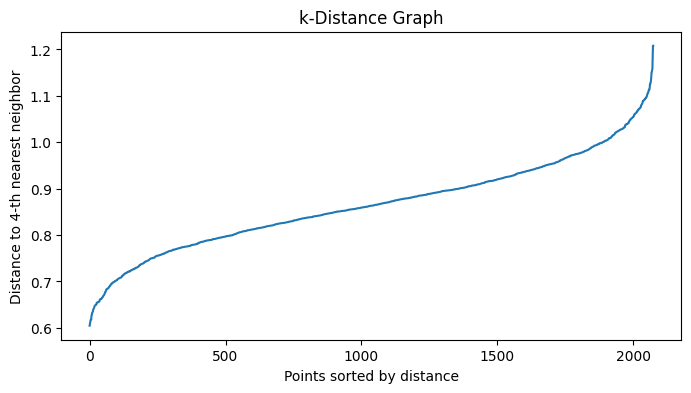

In [19]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Assuming `min_samples` is considered to be around 5 initially
min_samples = 5
neigh = NearestNeighbors(n_neighbors=min_samples)
nbrs = neigh.fit(description_embedding_lst)
distances, indices = nbrs.kneighbors(description_embedding_lst)

# Sort and plot distances to the (min_samples-1)th nearest neighbor
distances = np.sort(distances, axis=0)
distances = distances[:, min_samples-1]
plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title('k-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance to {}-th nearest neighbor'.format(min_samples-1))
plt.show()


In [20]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

perplexity_values = [10, 20, 30, 40, 50]  # Adjust based on your data size and complexity
epsilon_values = [0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7]  # Starting from the value found from k-distance
min_samples_values = [5, 10, 15, 20, 25]  # Sensible defaults based on data density

best_score = -1
best_params = {}

results = []

description_embedding_lst = np.array(description_embedding_lst)

for perplexity in perplexity_values:
    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    transformed = tsne.fit_transform(description_embedding_lst)
    
    for eps in epsilon_values:
        for min_samples in min_samples_values:
            # Apply DBSCAN
            clustering = DBSCAN(eps=eps, min_samples=min_samples)
            labels = clustering.fit_predict(transformed)
            
            if len(np.unique(labels)) > 1:  # Ensure there is more than 1 cluster
                score = silhouette_score(transformed, labels)
                results.append((perplexity, eps, min_samples, score))
                
                if score > best_score:
                    best_score = score
                    best_params = {'perplexity': perplexity, 'eps': eps, 'min_samples': min_samples}


In [21]:
print("Best silhouette score:", best_score)
print("Best parameters:", best_params)

# Optional: Convert results to DataFrame for easier handling
results_df = pd.DataFrame(results, columns=['Perplexity', 'Epsilon', 'Min Samples', 'Silhouette Score'])
print(results_df.sort_values(by='Silhouette Score', ascending=False).head())


Best silhouette score: 0.21272962
Best parameters: {'perplexity': 20, 'eps': 0.7, 'min_samples': 5}
    Perplexity  Epsilon  Min Samples  Silhouette Score
5           20      0.7            5          0.212730
30          50      0.5            5          0.086411
38          50      1.7            5          0.072372
28          40      1.7            5          0.051426
19          30      1.7            5          0.025142


In [44]:
df = pd.DataFrame(data = {
    'description': description_lst,
    'description_embedding': description_embedding_lst,
    'product_name': product_name_lst,
    'company_name': company_name_lst,
    'processed_name': processed_name_lst
})

In [45]:
df

,description,description_embedding,product_name,company_name,processed_name
0,A platform utilizing blockchain technology to ...,"[0.01961234211921692, -0.04968778416514397, -0...",Blockchain-Powered Phone System,HearRo,hearro
1,The software solutions provide tools for real-...,"[-0.010440151207149029, 0.0512225478887558, 0....",Construction Management and Production Trackin...,Raken,raken
2,Provides a range of accounting services and so...,"[-0.01257468294352293, 0.010148903355002403, 0...",Online Accounting Services,Crunch.,crunch_
3,Provides an index capturing the peer-to-peer o...,"[-0.006143645849078894, -0.032648079097270966,...",Index and Finance Technology Platform,CrowdBureau,crowdbureau
4,Provides a community for global citizens throu...,"[-0.007640076335519552, -0.008047102019190788,...",Global Community and Travel Platform,Yayem,yayem
...,...,...,...,...,...
2069,A range of personal and business banking produ...,"[-0.0005363529198803008, 0.007281074300408363,...","Bank Accounts, Savings, Loans, and Banking Ser...",Starling Bank,starling_bank
2070,Artificial arms capable of near-full human ran...,"[0.031287435442209244, 0.04793138802051544, -0...",AI-powered bionic arm,None,atom_limbs
2071,Provides comprehensive HR and payroll solution...,"[-0.019249044358730316, 0.000286013848381117, ...",HR and Payroll Software,Paycom,paycom
2072,Comprehensive financial and business services ...,"[-0.015923814848065376, 0.02055956795811653, 0...",Financial and Business Services,Cleveland Group,cleveland_group


In [46]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import plotly.express as px
import plotly.graph_objects as go

# Sample DataFrame setup
# Replace this with your actual DataFrame loading


# Assuming 'description_embedding' contains lists or arrays of embeddings
embeddings = np.vstack(df['description_embedding'])

# Initialize lists to store results
results = []

# Iterate over a range of hyperparameters
for perplexity in [10, 20, 30, 40, 50]:  # Adjust based on your data size and complexity
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    tsne_results = tsne.fit_transform(embeddings)
    
    for eps in [0.5, 0.7, 0.9, 1.1, 1.3, 1.5]:  # Adjust based on k-distance graph
        for min_samples in [5, 10, 15, 20]:  # Sensible defaults based on data density
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(tsne_results)
            
            if len(np.unique(labels)) > 1:  # Ensure there is more than 1 cluster
                score = silhouette_score(tsne_results, labels)
                results.append({
                    'perplexity': perplexity,
                    'epsilon': eps,
                    'min_samples': min_samples,
                    'silhouette_score': score
                })




In [49]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)
best_params = results_df.loc[results_df['silhouette_score'].idxmax()]

print(best_params)
results_df


perplexity          20.00000
epsilon              0.70000
min_samples          5.00000
silhouette_score     0.21273
Name: 4, dtype: float64


,perplexity,epsilon,min_samples,silhouette_score
0,10,0.9,5,-0.056615
1,10,1.1,5,-0.658891
2,10,1.3,5,-0.602797
3,10,1.5,5,-0.436649
4,20,0.7,5,0.212730
5,20,0.9,5,-0.621807
6,20,1.1,5,-0.619398
7,20,1.3,5,-0.451032
8,20,1.5,5,-0.218409
9,20,1.5,10,-0.226156


In [51]:
# Final t-SNE and DBSCAN with best parameters
tsne = TSNE(n_components=2, perplexity=best_params['perplexity'], random_state=42)
final_tsne_results = tsne.fit_transform(embeddings)
final_dbscan = DBSCAN(eps=best_params['epsilon'], min_samples=int(best_params['min_samples']))
final_labels = final_dbscan.fit_predict(final_tsne_results)

# 2D Visualization
fig_2d = px.scatter(x=final_tsne_results[:, 0], y=final_tsne_results[:, 1], color=final_labels.astype(str),
                    hover_data=[df['product_name'], df['company_name']])
fig_2d.update_layout(title='2D t-SNE Visualization of Product Embeddings', xaxis_title='Component 1', yaxis_title='Component 2')
fig_2d.show()

# If you need 3D visualization, run t-SNE with n_components=3 and repeat DBSCAN & plotting

HDBSCAN

In [4]:
df = pd.DataFrame(data = {
    'description': description_lst,
    'description_embedding': description_embedding_lst,
    'product_name': product_name_lst,
    'company_name': company_name_lst,
    'processed_name': processed_name_lst
})

In [7]:
import numpy as np
import hdbscan
from sklearn.decomposition import PCA
import plotly.express as px

# Generate sample data (replace this with your actual embeddings)
from sklearn.datasets import make_blobs

embeddings = df['description_embedding']  # Replace `data` with your actual embeddings

import numpy as np
import hdbscan
from sklearn.decomposition import PCA
import plotly.express as px
import pandas as pd

# Assuming `embeddings` is your array of text embeddings
# Assuming `product_names` is a list of names corresponding to these embeddings
product_names = df['product_name']  # Example names

embeddings = df['description_embedding']

if isinstance(embeddings, list):
    embeddings = np.array([np.array(embed) for embed in embeddings])
elif isinstance(embeddings, pd.Series):
    embeddings = np.stack(embeddings.values)
    
# Check the shape to ensure it's 2D
print('Embeddings shape:', embeddings.shape)

# Apply HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, gen_min_span_tree=True)
labels = clusterer.fit_predict(embeddings)

# Dimensionality Reduction for Visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(embeddings)

# Create a DataFrame for Plotly, including product names
df = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'])
df['Cluster'] = labels
df['Product Name'] = product_names  # Add product names to the DataFrame

# Visualization using Plotly
fig = px.scatter(df, x='PCA1', y='PCA2', color='Cluster', color_continuous_scale=px.colors.qualitative.Plotly,
                 hover_data=['Product Name'],
                 title="HDBSCAN Clustering with PCA Reduction",
                 labels={"Cluster": "Cluster ID", "PCA1": "Principal Component 1", "PCA2": "Principal Component 2"})
fig.update_traces(marker=dict(size=8))
fig.show()


Embeddings shape: (2074, 1536)


In [8]:
# Dimensionality Reduction for Visualization
pca = PCA(n_components=3)  # Change n_components to 3 for 3D visualization
reduced_data = pca.fit_transform(embeddings)

# Create a DataFrame for Plotly
df = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2', 'PCA3'])
df['Cluster'] = labels
df['Product Name'] = product_names  # Add product names to the DataFrame

# Visualization using Plotly in 3D
fig = px.scatter_3d(df, x='PCA1', y='PCA2', z='PCA3', color='Cluster', hover_data=['Product Name'],
                    title="HDBSCAN Clustering with 3D PCA Reduction",
                    labels={"Cluster": "Cluster ID"},
                    color_continuous_scale=px.colors.qualitative.Plotly)
fig.update_traces(marker=dict(size=5))
fig.show()

In [13]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import hdbscan
from sklearn.metrics import silhouette_score
import plotly.express as px

# Assuming embeddings and product_names are already defined
# Step 1: Dimensionality Reduction with t-SNE
tsne = TSNE(n_components=3, perplexity=30, random_state=42)  # Experiment with these parameters
tsne_results = tsne.fit_transform(embeddings)

# Step 2: Apply HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=10)
labels = clusterer.fit_predict(tsne_results)

# Step 3: Evaluate Clustering
if np.unique(labels).size > 1:  # Ensure we have more than one cluster
    score = silhouette_score(tsne_results, labels)
    print("Silhouette Score:", score)

# Step 4: Visualization
df = pd.DataFrame(tsne_results, columns=['Dim1', 'Dim2', 'Dim3'])
df['Cluster'] = labels
df['Product Name'] = product_names

fig = px.scatter_3d(df, x='Dim1', y='Dim2', z='Dim3', color='Cluster', hover_data=['Product Name'],
                    title="t-SNE and HDBSCAN Clustering",
                    labels={"Cluster": "Cluster ID"},
                    color_continuous_scale=px.colors.qualitative.Plotly)
fig.show()




Silhouette Score: -0.15827961


In [14]:
# Dimensionality reduction for 2D visualization
tsne_2d = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results_2d = tsne_2d.fit_transform(embeddings)

# Dimensionality reduction for 3D visualization
tsne_3d = TSNE(n_components=3, perplexity=30, random_state=42)
tsne_results_3d = tsne_3d.fit_transform(embeddings)

# Create DataFrames for Plotly visualization
df_2d = pd.DataFrame(tsne_results_2d, columns=['Dim1', 'Dim2'])
df_2d['Cluster'] = labels
df_2d['Product Name'] = product_names

df_3d = pd.DataFrame(tsne_results_3d, columns=['Dim1', 'Dim2', 'Dim3'])
df_3d['Cluster'] = labels
df_3d['Product Name'] = product_names


In [15]:
# 2D Visualization
fig_2d = px.scatter(df_2d, x='Dim1', y='Dim2', color='Cluster', hover_data=['Product Name'],
                    title="2D t-SNE Visualization of HDBSCAN Clusters",
                    labels={"Cluster": "Cluster ID"},
                    color_continuous_scale=px.colors.qualitative.Plotly)
fig_2d.show()

# 3D Visualization
fig_3d = px.scatter_3d(df_3d, x='Dim1', y='Dim2', z='Dim3', color='Cluster', hover_data=['Product Name'],
                       title="3D t-SNE Visualization of HDBSCAN Clusters",
                       labels={"Cluster": "Cluster ID"},
                       color_continuous_scale=px.colors.qualitative.Plotly)
fig_3d.show()


V3 HDBSCAN

In [10]:
import numpy as np
import pandas as pd
import hdbscan
from sklearn.metrics import silhouette_score

# Assuming `embeddings` and `product_names` are already defined
# Apply HDBSCAN directly to high-dimensional embeddings
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=10)
labels = clusterer.fit_predict(embeddings)

# Evaluate Clustering
if np.unique(labels).size > 1:
    score = silhouette_score(embeddings, labels)
    print("Silhouette Score:", score)


Silhouette Score: -0.03483987353336772


In [11]:
from sklearn.manifold import TSNE
import plotly.express as px

# Dimensionality reduction for 2D visualization
tsne_2d = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results_2d = tsne_2d.fit_transform(embeddings)

# Dimensionality reduction for 3D visualization
tsne_3d = TSNE(n_components=3, perplexity=30, random_state=42)
tsne_results_3d = tsne_3d.fit_transform(embeddings)

# Create DataFrames for Plotly visualization
df_2d = pd.DataFrame(tsne_results_2d, columns=['Dim1', 'Dim2'])
df_2d['Cluster'] = labels
df_2d['Product Name'] = product_names

df_3d = pd.DataFrame(tsne_results_3d, columns=['Dim1', 'Dim2', 'Dim3'])
df_3d['Cluster'] = labels
df_3d['Product Name'] = product_names


In [12]:
# 2D Visualization
fig_2d = px.scatter(df_2d, x='Dim1', y='Dim2', color='Cluster', hover_data=['Product Name'],
                    title="2D t-SNE Visualization of HDBSCAN Clusters",
                    labels={"Cluster": "Cluster ID"},
                    color_continuous_scale=px.colors.qualitative.Plotly)
fig_2d.show()

# 3D Visualization
fig_3d = px.scatter_3d(df_3d, x='Dim1', y='Dim2', z='Dim3', color='Cluster', hover_data=['Product Name'],
                       title="3D t-SNE Visualization of HDBSCAN Clusters",
                       labels={"Cluster": "Cluster ID"},
                       color_continuous_scale=px.colors.qualitative.Plotly)
fig_3d.show()
